In [2]:
# Load packages
import importlib
import scripts.vrae  # your module
importlib.reload(scripts.vrae)

import sys
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns



# Load local scripts
# Add scripts folder to sys.path so scripts can be imported
sys.path.insert(1, 'scripts')
from scripts.data_functions import load_ecg_data,addDamicAdmissionData, load_selected_ecg
from scripts.visualisation import plot_ecgs_per_location, plot_ecgs_at_ICU, plot_ecgs_per_year

from scripts.vrae import VRAE
from scripts.utils import *
# ============= #
# Load ECG data #
# ============= #

# Set quickload to True if you only want to quickly read the ECG metadata.
# Set quickload to False if you want to load all ECG data including the
# waveform data (this can take multiple hours).
quickload = True
makePlots = False # Set to True for overview plots
save = True

# Specify folder directories
data_path = r"L:/SPEC/ICU/RESEARCH/Data-onderzoek/ECG dataset/data"
local_ecg_path = r"L:/SPEC/ICU/RESEARCH/Data-onderzoek/ECG dataset/XML subset"
figure_path = "figures"

Run quickloads and make plots

In [3]:
if quickload:
    df_ecg = load_ecg_data(data_path = data_path,
                           quickload = quickload)
else:
    load_ecg_data(local_ecg_path = local_ecg_path, quickload = quickload)

# =============== #
# Add DAM-IC data #
# =============== #
# Load DAM-IC data
mostRecentDamicFile = r"L:\SPEC\ICU\RESEARCH\Data-onderzoek\Basisdataset\DAM-IC\Definitief cohort versies\ADAMICPatientCohort_HrCorrected2013-2023_hashed_2024-10-15.csv"
df_ecg=addDamicAdmissionData(df_ecg, mostRecentDamicFile)



# ============== #
# Visualise data #
# ============== #
if makePlots:
    plot_ecgs_per_location(df_ecg, save = save, save_path = figure_path)

    plot_ecgs_at_ICU(df_ecg, save = save, save_path = figure_path)

    plot_ecgs_per_year(df_ecg, save = save, save_path = figure_path)

L:\SPEC\ICU\RESEARCH\Data-onderzoek\studenten\Econometrie\Bao Phung\ECG loading scripts\scripts\data_functions.py:409: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-58 days +12:09:09' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data.loc[ind,"timeSincePrevIcu"] = max(timeDifs)
L:\SPEC\ICU\RESEARCH\Data-onderzoek\studenten\Econometrie\Bao Phung\ECG loading scripts\scripts\data_functions.py:396: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0 days 00:00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data.loc[ind,"timeToNextIcu"] = zeroTimeDelta


Data Overview

,filename,PatientID,PatientAge,PatientAge.1,Gender,DataType,Site,SiteName,RoomID,AcquisitionDevice,...,AcquisitionDateTime,isBeforeIcu,isAfterIcu,isDuringIcu,timeToNextIcu,timeSincePrevIcu,uniqueEncId,isDuring24HrICU,timeToNextIcu_hours,timeSincePrevIcu_hours
0,MUSE_20240429_164621_29000.XML,61124542.0,78.0,78.0,MALE,RESTING,1,MUMC+,SEH 20,DatamedFT,...,2023-12-30 21:50:51,0,1,0,NaT,-58 days +12:09:09,<NA>,0,NaN,-1379.847500
1,MUSE_20240429_164622_89000.XML,61124542.0,78.0,78.0,MALE,RESTING,1,MUMC+,SEH 20,DatamedFT,...,2023-12-30 21:51:46,0,1,0,NaT,-58 days +12:08:14,<NA>,0,NaN,-1379.862778
2,MUSE_20240429_164624_33000.XML,41240760.0,88.0,88.0,FEMALE,RESTING,1,MUMC+,SEH 10,DatamedFT,...,2023-12-30 23:58:43,0,1,0,NaT,-1895 days +10:01:17,<NA>,0,NaN,-45469.978611
3,MUSE_20240429_164625_15000.XML,72524034.0,68.0,68.0,FEMALE,RESTING,1,MUMC+,NaN,MAC55,...,2023-12-30 21:14:25,0,1,0,NaT,-2 days +14:45:35,<NA>,0,NaN,-33.240278
4,MUSE_20240429_164626_90000.XML,72524034.0,68.0,68.0,FEMALE,RESTING,1,MUMC+,NaN,MAC55,...,2023-12-30 21:14:06,0,1,0,NaT,-2 days +14:45:54,<NA>,0,NaN,-33.235000
5,MUSE_20240429_164628_49000.XML,72524034.0,68.0,68.0,FEMALE,RESTING,1,MUMC+,NaN,MAC55,...,2023-12-30 21:12:47,0,1,0,NaT,-2 days +14:47:13,<NA>,0,NaN,-33.213056
6,MUSE_20240429_164629_34000.XML,61782061.0,73.0,73.0,FEMALE,RESTING,1,MUMC+,SEH 14,DatamedFT,...,2023-12-30 19:53:17,0,1,0,NaT,-2366 days +20:06:43,<NA>,0,NaN,-56763.888056
7,MUSE_20240429_164631_93000.XML,21048206.0,76.0,76.0,FEMALE,RESTING,1,MUMC+,NaN,MAC55,...,2023-12-30 18:35:33,0,0,0,NaT,NaT,<NA>,0,NaN,NaN
8,MUSE_20240429_164632_84000.XML,21048206.0,76.0,76.0,FEMALE,RESTING,1,MUMC+,NaN,MAC55,...,2023-12-30 16:31:21,0,0,0,NaT,NaT,<NA>,0,NaN,NaN
9,MUSE_20240429_164633_32000.XML,21048206.0,76.0,76.0,FEMALE,RESTING,1,MUMC+,NaN,MAC55,...,2023-12-30 16:25:33,0,0,0,NaT,NaT,<NA>,0,NaN,NaN


Total observations: 295813
Observations with an encounter ID (ICU): 36569
Percentage of observations with a unique encounter ID: 12.36%


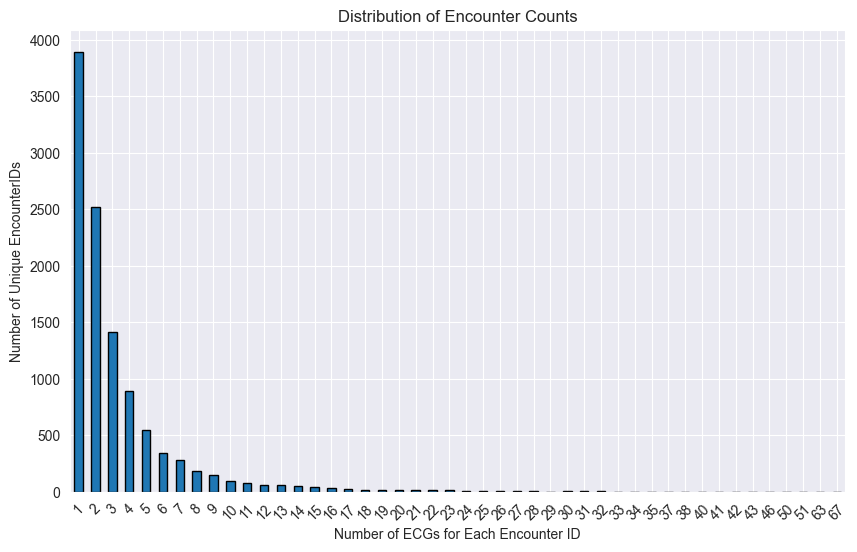

In [4]:
# Look at head of df
display(df_ecg.head(10))

# Proportion of patients with unique encounter ID
total_observations =  df_ecg.shape[0]
icu_observations = df_ecg['uniqueEncId'].notna().sum()
percentage_with_encounter_id = icu_observations / df_ecg.shape[0] * 100

print(f"Total observations: {total_observations}")
print(f"Observations with an encounter ID (ICU): {icu_observations}")
print(f"Percentage of observations with a unique encounter ID: {percentage_with_encounter_id:.2f}%")


def encounter_counts_plot(df):
    """
    Plots a histogram where the x-axis represents the number of rows for each unique EncounterID
    and the y-axis represents how many unique EncounterIDs have that number of rows.

    Parameters:
    df (pandas.DataFrame): The dataframe containing the 'EncounterID' column.
    """
    # Count the occurrences of each EncounterID using value_counts()
    encounter_counts = df['uniqueEncId'].value_counts()

    # Count how many EncounterIDs have the same number of rows
    encounter_frequency = encounter_counts.value_counts()

    #

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    encounter_frequency.sort_index().plot(kind='bar', edgecolor='black')
    plt.title('Distribution of Encounter Counts')
    plt.xlabel('Number of ECGs for Each Encounter ID')
    plt.ylabel('Number of Unique EncounterIDs')
    plt.xticks(rotation=45)
    plt.show()

# Call the function with your dataframe
encounter_counts_plot(df_ecg)

In [5]:
# Count how many patients that has an ECG recording during the first 24 hours of ICU admission.
def count_ecg_within_24h(df_ecg):
    """
    Counts unique patients with at least one ECG recorded in the first 24 hours of ICU admission.
    Also calculates the percentage of these patients out of all unique patients.

    Parameters:
        df_ecg (pd.DataFrame): DataFrame containing ECG data with columns 'uniqueEncId' and 'isDuring24HrICU'.

    Returns:
        tuple: (count of patients with ECG in first 24h, percentage of total patients)
    """

    # Count unique patients who had an ECG within the first 24 hours
    unique_patients_24h = df_ecg[df_ecg["isDuring24HrICU"] == 1]["uniqueEncId"].nunique()

    # Count total unique patients
    total_unique_patients = df_ecg["uniqueEncId"].nunique()

    # Compute percentage
    percentage_24h = (unique_patients_24h / total_unique_patients) * 100 if total_unique_patients > 0 else 0

    return unique_patients_24h, percentage_24h


# Apply to df_ecg
num_patients, percent_patients = count_ecg_within_24h(df_ecg)
print(f"Unique patients with ECG in first 24h: {num_patients}")
print(f"Percentage of those patients out of total patients: {percent_patients:.2f}%")


# Find the earliest ECG (by AcquisitionDateTime) for each unique patient who had at least one ECG recorded in the first 24 hours of ICU admission.
def get_first_ecg_within_24h(df_ecg):
    """
    Finds the earliest ECG (by AcquisitionDateTime) for each unique patient (uniqueEncId)
    who had at least one ECG recorded in the first 24 hours of ICU admission (isDuring24HrICU == 1).

    Parameters:
        df_ecg (pd.DataFrame): DataFrame containing ECG data with columns 'uniqueEncId', 'isDuring24HrICU',
                               'AcquisitionDateTime', and 'filename'.

    Returns:
        pd.DataFrame: A DataFrame with 'filename' and 'uniqueEncId' for the first ECG recorded within 24h.
    """

    # Filter only records where isDuring24HrICU is 1
    df_24h = df_ecg[df_ecg["isDuring24HrICU"] == 1]

    # Find the first (earliest) ECG per uniqueEncId
    df_first_ecg = df_24h.loc[
        df_24h.groupby("uniqueEncId")["AcquisitionDateTime"].idxmin(), ["filename", "uniqueEncId"]]

    return df_first_ecg


# Apply to df_ecg
df_first_ecg = get_first_ecg_within_24h(df_ecg)
print(df_first_ecg.head())

Unique patients with ECG in first 24h: 9074
Percentage of those patients out of total patients: 83.63%
                              filename uniqueEncId
172859  MUSE_20240502_162122_67000.XML       23872
76062   MUSE_20240430_231805_60000.XML     1719688
107339  MUSE_20240501_121655_57000.XML     1757036
226202  MUSE_20240503_153423_42000.XML     2895998
6339    MUSE_20240429_190151_87000.XML     4605079


In [6]:
# Find the earliest ECG (by AcquisitionDateTime) for each unique patient who had at least one ECG recorded in the first 24 hours of ICU admission.
def get_first_ecg_within_24h(df_ecg):
    """
    Finds the earliest ECG (by AcquisitionDateTime) for each unique patient (uniqueEncId)
    who had at least one ECG recorded in the first 24 hours of ICU admission (isDuring24HrICU == 1).

    Parameters:
        df_ecg (pd.DataFrame): DataFrame containing ECG data with columns 'uniqueEncId', 'isDuring24HrICU',
                               'AcquisitionDateTime', and 'filename'.

    Returns:
        pd.DataFrame: A DataFrame with 'filename' and 'uniqueEncId' for the first ECG recorded within 24h.
    """

    # Filter only records where isDuring24HrICU is 1
    df_24h = df_ecg[df_ecg["isDuring24HrICU"] == 1]

    # Find the first (earliest) ECG per uniqueEncId
    df_first_ecg = df_24h.loc[df_24h.groupby("uniqueEncId")["AcquisitionDateTime"].idxmin(), ["filename", "uniqueEncId"]]

    return df_first_ecg

# Apply to df_ecg
df_first_ecg = get_first_ecg_within_24h(df_ecg)
print(df_first_ecg.head())

                              filename uniqueEncId
172859  MUSE_20240502_162122_67000.XML       23872
76062   MUSE_20240430_231805_60000.XML     1719688
107339  MUSE_20240501_121655_57000.XML     1757036
226202  MUSE_20240503_153423_42000.XML     2895998
6339    MUSE_20240429_190151_87000.XML     4605079


In [7]:
df_selected_wave, x_ecg, ecg_data = load_selected_ecg(
    selected=df_first_ecg.iloc[:1000],  # Take first 1000 rows
    local_ecg_path=r"L:/SPEC/ICU/RESEARCH/Data-onderzoek/ECG dataset/XML Rosmalen",
    data_path=data_path,
    scale = True,  # Standardize the data
    save=False
)

Processed 0/1000 ECG files...
Processed 300/1000 ECG files...
Processed 400/1000 ECG files...
Processed 600/1000 ECG files...
Processed 800/1000 ECG files...
Processed 900/1000 ECG files...
Loading ECGs took 1.87 minutes.
Excluded 0 files due to excess leads.
Excluded 217 files due to missing numeric ECG values.


In [8]:
# Check basic info
print(df_selected_wave.info())

# Show first few rows
print(df_selected_wave.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   filename             783 non-null    object        
 1   PatientID            783 non-null    object        
 2   PatientAge           783 non-null    object        
 3   Gender               783 non-null    object        
 4   VentricularRate      783 non-null    object        
 5   AtrialRate           783 non-null    object        
 6   PRInterval           783 non-null    object        
 7   QRSDuration          783 non-null    object        
 8   QTInterval           783 non-null    object        
 9   QTCorrected          783 non-null    object        
 10  PAxis                783 non-null    object        
 11  RAxis                783 non-null    object        
 12  TAxis                783 non-null    object        
 13  QRSCount             783 non-null  

In [8]:
# Select numeric ECG features
ecg_intervals = ["VentricularRate", "AtrialRate", "PRInterval", "QRSDuration", "QTInterval", "QTCorrected", "PAxis", "RAxis", "TAxis", "QRSCount"]
df_selected_wave[ecg_intervals].describe()

,VentricularRate,AtrialRate,PRInterval,QRSDuration,QTInterval,QTCorrected,PAxis,RAxis,TAxis,QRSCount
count,783,783,783,783,783,783,783,783,783,783
unique,95,105,154,100,186,174,141,203,238,22
top,80,80,162,86,402,452,66,-3,63,13
freq,64,55,29,44,18,17,19,13,13,126


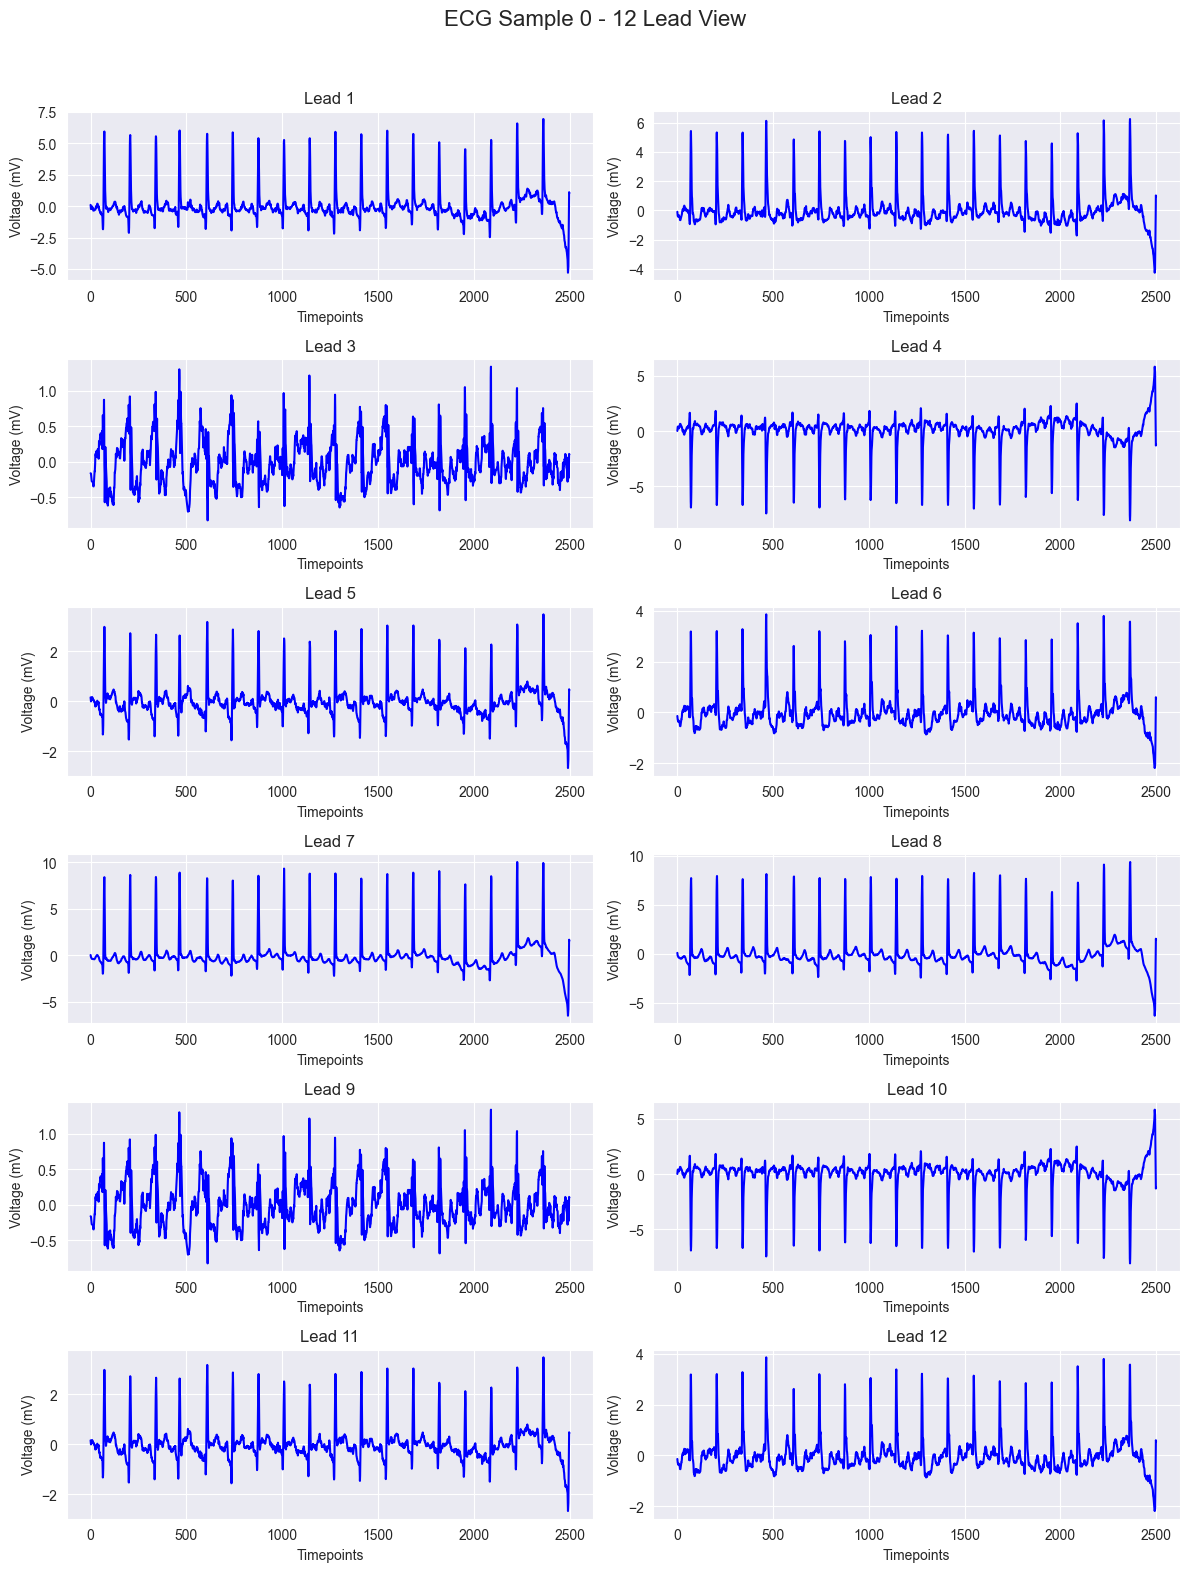

In [9]:
def plot_ecg_example(ecg_data, sample_idx=0, leads=list(range(12)), time_range=None):
    """
    Plots 12 ECG leads of a sample as separate subplots in one figure (3x4 layout).

    Parameters:
    - ecg_data: numpy array of shape (n_samples, n_timepoints, n_leads)
    - sample_idx: index of the ECG sample to plot
    - leads: list of lead indices to plot (default: all 12 leads)
    - time_range: tuple (start, end) to zoom in (default: full length)
    """
    timepoints = ecg_data.shape[1]
    if time_range is None:
        time_range = (0, timepoints)

    fig, axes = plt.subplots(6, 2, figsize=(12, 16))
    axes = axes.flatten()

    for i, lead in enumerate(leads):
        ax = axes[i]
        signal = ecg_data[sample_idx, time_range[0]:time_range[1], lead]
        ax.plot(range(time_range[0], time_range[1]), signal, color='blue')
        ax.set_title(f"Lead {lead + 1}")
        ax.set_xlabel("Timepoints")
        ax.set_ylabel("Voltage (mV)")
        ax.grid(True)

    # Hide any unused subplots if fewer than 12 leads
    for j in range(len(leads), len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"ECG Sample {sample_idx} - 12 Lead View", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage
plot_ecg_example(x_ecg, sample_idx=0)


Verify the shape and type of the ECG data
Standardize the data for VRAE application

In [10]:
# Check type and shape of the data
print("Type of x_ecg:", type(x_ecg))
if isinstance(x_ecg, np.ndarray):
    print("Shape of x_ecg:", x_ecg.shape)  # (n_samples, n_timepoints, n_leads)
    print("Number of samples:", x_ecg.shape[0])
    print("Number of timepoints per sample:", x_ecg.shape[1])
    print("Number of leads per sample:", x_ecg.shape[2])
else:
    raise ValueError("x_ecg is not a numpy array")

# Standardize the data

Type of x_ecg: <class 'numpy.ndarray'>
Shape of x_ecg: (783, 2500, 12)
Number of samples: 783
Number of timepoints per sample: 2500
Number of leads per sample: 12


Apply VRAE:
- Split data
- Set up model parameters

In [12]:
# Add plot function for train vs validation losses
import matplotlib.pyplot as plt

def plot_losses(model, title=None):
    plt.figure(figsize=(8, 5))
    plt.plot(model.train_losses, label='Train Loss')
    if hasattr(model, 'val_losses') and model.val_losses:
        plt.plot(model.val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title or "Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [13]:
# Check correct standardization
import numpy as np

lead_means = np.mean(x_ecg, axis=(0, 1))
lead_stds = np.std(x_ecg, axis=(0, 1))

print("Per-lead mean after standardization:")
print(np.round(lead_means, 4))

print("\nPer-lead std after standardization:")
print(np.round(lead_stds, 4))


Per-lead mean after standardization:
[ 0.  0.  0.  0. -0.  0.  0.  0.  0.  0. -0.  0.]

Per-lead std after standardization:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Training with params: {'batch_size': 16, 'hidden_size': 128, 'latent_length': 5, 'learning_rate': 0.001}
Epoch: 1/50


C:\Users\G10070127\.conda\envs\PythonProject\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Batch 10, loss = 480007.0312, recon_loss = 480006.9688, kl_loss = 0.0515
Batch 20, loss = 480021.7500, recon_loss = 480021.5938, kl_loss = 0.1425
Batch 30, loss = 480006.3750, recon_loss = 480006.2188, kl_loss = 0.1528
Batch 40, loss = 480006.0938, recon_loss = 480006.0625, kl_loss = 0.0303
Average loss: 491131.0044
Epoch: 2/50
Batch 10, loss = 480001.8125, recon_loss = 480001.7812, kl_loss = 0.0235
Batch 20, loss = 480012.7500, recon_loss = 480012.7188, kl_loss = 0.0174
Batch 30, loss = 479979.0312, recon_loss = 479979.0000, kl_loss = 0.0196
Batch 40, loss = 480000.3750, recon_loss = 480000.3438, kl_loss = 0.0185
Average loss: 490990.2682
Epoch: 3/50
Batch 10, loss = 479997.6250, recon_loss = 479997.5625, kl_loss = 0.0641
Batch 20, loss = 479992.3125, recon_loss = 479992.1875, kl_loss = 0.1312
Batch 30, loss = 480002.9062, recon_loss = 480002.7500, kl_loss = 0.1654
Batch 40, loss = 480001.8125, recon_loss = 480001.6250, kl_loss = 0.1760
Average loss: 490989.4164
Epoch: 4/50
Batch 10, 

AttributeError: 'VRAE' object has no attribute 'val_losses'

In [ ]:
# Run without print val loss

# Trying grid search to tune hyperparameters (train loss only)
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from sklearn.model_selection import ParameterGrid

# === Setup ===
output_dir = './ecg_model_logs'
os.makedirs(output_dir, exist_ok=True)
log_path = os.path.join(output_dir, 'training_log.txt')
best_model_path = os.path.join(output_dir, 'best_model.pth')

# === Load Data ===
train_dataset = TensorDataset(torch.from_numpy(x_ecg).float())

# Hyperparameter Search Space
param_grid = {
    'hidden_size': [32, 64, 128],
    'latent_length': [5, 15, 30],
    'batch_size': [16],
    'learning_rate': [1e-3, 5e-4],
}

# Fixed Parameters
sequence_length = x_ecg.shape[1]
number_of_features = x_ecg.shape[2]
hidden_layer_depth = 2
n_epochs = 50
optimizer = 'Adam'
cuda = torch.cuda.is_available()
print_every = 10
clip = True
max_grad_norm = 5
loss = 'MSELoss'
block = 'LSTM'
dropout = 0.2

# Tracking Best Model
best_train_loss = float('inf')
best_params = None

# Training Loop
for params in ParameterGrid(param_grid):
    with open(log_path, 'a') as f:
        f.write(f"\n=== Training with params: {params} ===\n")

    print(f"Training with params: {params}")

    if hidden_layer_depth == 1 and dropout != 0:
        print("⚠️ Warning: Dropout is not used when hidden_layer_depth = 1 in PyTorch RNNs.\n")

    vrae = VRAE(
        sequence_length=sequence_length,
        number_of_features=number_of_features,
        hidden_size=params['hidden_size'],
        hidden_layer_depth=hidden_layer_depth,
        latent_length=params['latent_length'],
        batch_size=params['batch_size'],
        learning_rate=params['learning_rate'],
        n_epochs=n_epochs,
        dropout_rate=dropout,
        optimizer=optimizer,
        cuda=cuda,
        print_every=print_every,
        clip=clip,
        max_grad_norm=max_grad_norm,
        loss=loss,
        block=block,
        dload=output_dir
    )

    # Timing & Training
    start_time = time.time()
    vrae.fit(train_dataset)
    end_time = time.time()
    runtime = end_time - start_time

    avg_train_loss = np.mean(vrae.train_losses)

    # Logging results
    with open(log_path, 'a') as f:
        f.write(f"Final training loss: {avg_train_loss:.4f}\n")
        f.write(f"Training time: {runtime:.2f} seconds\n")

    # Plot losses
    plt.figure()
    plt.plot(vrae.train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Train Loss - hidden_size={params['hidden_size']}, latent={params['latent_length']}")
    plt.legend()
    plot_file = os.path.join(output_dir, f"loss_curve_h{params['hidden_size']}_l{params['latent_length']}.png")
    plt.savefig(plot_file)
    plt.close()

    # Save best model
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        best_params = params
        torch.save(vrae.state_dict(), best_model_path)

# Final Log
with open(log_path, 'a') as f:
    f.write(f"\nBest model: {best_params} with train loss: {best_train_loss:.4f}\n")
print(f"✅ Best model saved with train loss: {best_train_loss:.4f}")




Training with params: {'batch_size': 16, 'hidden_size': 32, 'latent_length': 5, 'learning_rate': 0.001}
Epoch: 1/50
Batch 10, loss = 0.7831, recon_loss = 0.7795, kl_loss = 0.0036
Batch 20, loss = 1.0942, recon_loss = 1.0939, kl_loss = 0.0003


________________________________________________

To-do when finish tuning parameters:
- Plot cluster
- Choosing number of clusters: k-means/DBSCAN -> calculate Silhouette score and other metrics to find appropriate number of clusters
- Discussion of results:
* Compare extracted latent features with ECG numeric (Prof.Stephan's references)
* Check if clusters have medical interpretation
* Cluster stability analysis: Jaccard similarity

In [4]:
# z_run = vrae.transform()


NameError: name 'vrae' is not defined

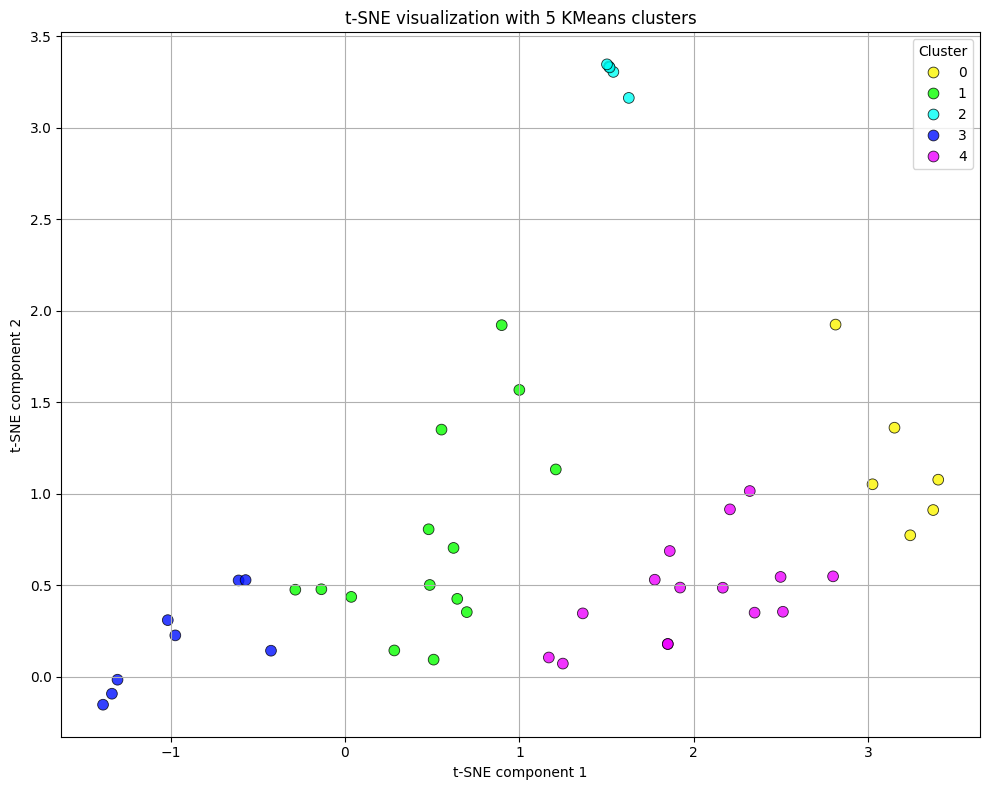

In [45]:
# T-SNE Plotting after K-means clustering
#
# Step 1: Run t-SNE
z_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(z_run)

# Step 2: Apply KMeans clustering
n_clusters = 5  # Adjust this as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(z_run)

# Step 3: Plot with Seaborn for better aesthetics
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", n_clusters)  # bright, distinguishable colors

sns.scatterplot(x=z_2d[:, 0], y=z_2d[:, 1], hue=clusters, palette=palette, s=60, alpha=0.8, edgecolor='black')
plt.title(f't-SNE visualization with {n_clusters} KMeans clusters')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
# Test some comparisons (chua check, copied from chatpgt)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# ECG interval feature columns
ecg_intervals = [
    "VentricularRate", "AtrialRate", "PRInterval", "QRSDuration",
    "QTInterval", "QTCorrected", "PAxis", "RAxis", "TAxis", "QRSCount"
]

# Step 1: Extract ECG numeric features and standardize
ecg_features = df_selected_wave[ecg_intervals].to_numpy()
ecg_features = StandardScaler().fit_transform(ecg_features)

# View ecg_features head
print("ECG Features (first 5 rows):")
print(ecg_features[:5])

ECG Features (first 5 rows):
[[ 1.12940788e+00  6.06384695e-01 -1.38228843e-01 -1.43416535e-04
  -6.67199889e-01  2.85223238e-01 -4.29062619e-01  9.86212507e-02
  -1.20314932e+00  1.09884256e+00]
 [ 4.44866398e-01  2.32246367e-01 -9.90102855e-01  7.15648511e-02
  -6.37159372e-01 -2.88395009e-01  6.18708296e-01  2.02251287e-01
  -6.04323146e-01  5.73583209e-01]
 [-4.10810459e-01 -2.35426543e-01 -1.88339079e-01  2.65306249e+00
   1.37555529e+00  1.39871748e+00  5.33753898e-01  1.22628876e-02
  -6.32838678e-01 -2.14305814e-01]
 [-3.25242773e-01 -1.88659252e-01 -1.09032333e+00 -1.00405916e+00
  -4.56916268e-01 -8.11399881e-01 -3.44108220e-01 -6.09517327e-01
  -1.19559099e-01 -2.14305814e-01]
 [ 7.01569455e-01  3.72548240e-01 -1.26570915e+00 -1.47016290e+00
  -1.29805075e+00 -9.96982255e-01  9.30207757e-01  8.41303174e-01
   2.86031402e+00  8.36212884e-01]]


In [53]:
print("Total NaNs in ECG features:", df_selected_wave[ecg_intervals].isna().sum().sum())
print(df_selected_wave[ecg_intervals][df_selected_wave[ecg_intervals].isna().any(axis=1)].head())
print(df_selected_wave[ecg_intervals].isna().sum())


Total NaNs in ECG features: 194
   VentricularRate AtrialRate PRInterval QRSDuration QTInterval QTCorrected  \
5               93         35        NaN         220        504         626   
6              102        104        NaN          78        326         424   
14              61         59        NaN          90        404         406   
16             128        153        NaN          84        290         423   
17              77         77        152          88        416         470   

   PAxis RAxis TAxis QRSCount  
5    NaN   -34    -2       16  
6    NaN    72    53       16  
14    36   -17   164       10  
16   NaN    85   249       21  
17   NaN    84    92       13  
VentricularRate      0
AtrialRate           0
PRInterval          88
QRSDuration          0
QTInterval           0
QTCorrected          0
PAxis              104
RAxis                0
TAxis                2
QRSCount             0
dtype: int64


In [50]:
# Step 2: Run t-SNE on both VRAE output and ECG features
tsne_vrae = TSNE(n_components=2, random_state=42).fit_transform(z_run)
tsne_ecg = TSNE(n_components=2, random_state=42).fit_transform(ecg_features)

# Step 3: Plot both embeddings
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].scatter(tsne_vrae[:, 0], tsne_vrae[:, 1], alpha=0.7, c='tab:blue')
axs[0].set_title("VRAE Latent Features (Waveform)", fontsize=14)

axs[1].scatter(tsne_ecg[:, 0], tsne_ecg[:, 1], alpha=0.7, c='tab:green')
axs[1].set_title("Standard ECG Intervals (Numeric)", fontsize=14)

plt.tight_layout()
plt.show()

# Step 4: Compare with silhouette scores using KMeans
print("Silhouette Scores with KMeans clustering (k=5):")
for data, name in zip([z_run, ecg_features], ["VRAE", "ECG Intervals"]):
    kmeans = KMeans(n_clusters=5, random_state=42).fit(data)
    score = silhouette_score(data, kmeans.labels_)
    print(f"  {name}: {score:.3f}")


ValueError: Input X contains NaN.
TSNE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values